In [141]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install texthero

In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotib inline
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from mpl_toolkits.mplot3d import Axes3D

In [144]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import texthero as hero
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
import nltk.data
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import word_tokenize
nltk.download('vader_lexicon')
nltk.download('punkt')
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [145]:
def embed_glove(model, s):
    #print(s)
    return_ls = []
    for sentence in s:
        array = []
        for word in str(sentence).split():
            try:
                array.append(model.get_vector(word))
            except:
                pass
        array = np.array(array)
        #print(array.shape)
        return_ls.append(array.mean(axis = 0))
    return return_ls

In [146]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/sNLP_project/SongRecommendationChatBot/analysis/word_embedding_model')

In [147]:
from gensim.scripts.glove2word2vec import glove2word2vec
# Convert
input_file = 'new_glove.6B.100d.txt'
output_file = 'gensim_glove.6B.100d.txt'
glove2word2vec(input_file, output_file)

# Test Glove model
model = KeyedVectors.load_word2vec_format(output_file, binary=False)
word = 'cat'
print(word)
print('Most similar:\n{}'.format(model.most_similar(word)))

cat
Most similar:
[('dog', 0.8798074722290039), ('rabbit', 0.7424426674842834), ('cats', 0.7323004007339478), ('monkey', 0.7288709878921509), ('pet', 0.7190139889717102), ('dogs', 0.7163872718811035), ('mouse', 0.6915250420570374), ('puppy', 0.6800068020820618), ('rat', 0.6641027331352234), ('spider', 0.6501135230064392)]


In [148]:
def setimentanalyzer(df):
    neg='Negative'
    neu='Neutral'
    pos='Positive'
    negative = []
    neutral = []
    positive = []
    dominant_sentiment=[]
    dominant_sentiment_score=[]
    #Initialize the model
    sid = SentimentIntensityAnalyzer()
    #Iterate for each row of lyrics and append the scores
    for i in df.index:
       
        scores = sid.polarity_scores(df['Lyric'].iloc[i])
        negative.append(scores['neg'])
        neutral.append(scores['neu'])
        positive.append(scores['pos'])
        if scores['neg']>scores['pos']:
            dominant_sentiment_score.append(scores['neg'])
            dominant_sentiment.append(neg)
        elif scores['neg']<scores['pos']:
            dominant_sentiment_score.append(scores['pos'])
            dominant_sentiment.append(pos)
        else:
            dominant_sentiment_score.append(scores['neu'])
            dominant_sentiment.append(neu)
    #Create 5 columns to the main data frame  for each score
    df['negative'] = negative
    df['neutral'] = neutral
    df['positive'] = positive
    df['dominant_sentiment']=dominant_sentiment
    df['dominant_sentiment_score']=dominant_sentiment_score
    return df

In [ ]:
#load the data
df = pd.read_csv('../data/TaylorSwift.csv')
df['embedded'] = embed_glove(model, df['Lyric'])
df = df.dropna()
df = df.reset_index()
df.head()

In [ ]:
#album name
album_name = list(set(df.Album))
album_num = []
for i in range(df.shape[0]):
  album = str(df.Album[i])
  album_num.append(album_name.index(album))
df['Album_num'] = album_num
df.head()

tsne with sklearn

In [151]:
#embedding
embedding = np.stack([i for i in df.embedded],axis=0)
df_embed = pd.concat([df,pd.DataFrame(embedding)],axis=1)
#tsne
tsne = TSNE(n_components=3)
df_tsne1 = tsne.fit_transform(df_embed.iloc[:,9:])
df_tsne1 = pd.DataFrame(df_tsne1,
                            columns =["Component1","Component2","Component3"])
df_tsne1.to_csv('../data/df_tsne1.csv')

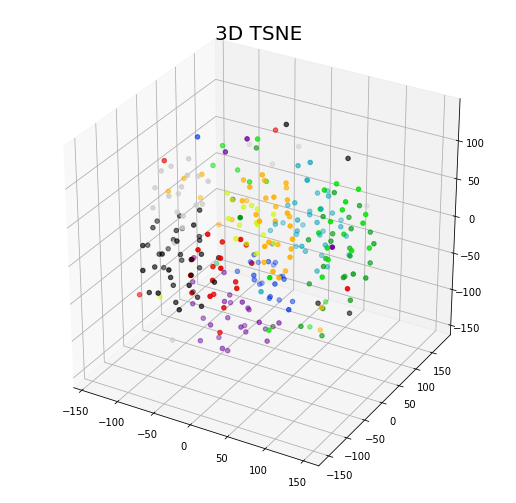

In [172]:
#Visualizing 3D
#scattered one
figure = plt.figure(figsize=(9,9))
axes = figure.add_subplot(111,projection = "3d")
dots = axes.scatter(xs = df_tsne1.iloc[:,0],ys = df_tsne1.iloc[:,1],zs = df_tsne1.iloc[:,2],
                   c = df.Album_num, cmap = plt.cm.get_cmap("nipy_spectral_r",10))
axes.set_title("3D TSNE",fontsize=20)
plt.savefig('../3d_tsne1.png')

tsne with text hero

In [164]:
#tsne with text hero
df['tsne'] = hero.tsne(df['embedded'],n_components=3)
df['c1'] = [i for i,_,_ in df['tsne']]
df['c2'] = [i for _,i,_ in df['tsne']]
df['c3'] = [i for _,_,i in df['tsne']]
df_tsne2 = df[['Album_num','c1', 'c2', 'c3']]
df_tsne2.to_csv('../data/df_tsne2.csv')

Text(0.5, 0.92, '3D tsne2')

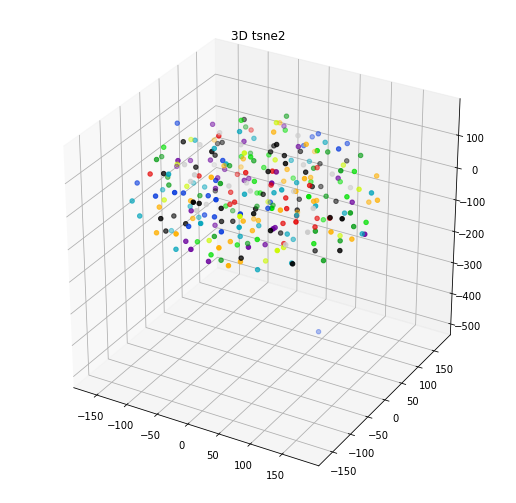

In [165]:
#Visualizing 3D
#scattered one
figure = plt.figure(figsize=(9,9))
axes = figure.add_subplot(111,projection = "3d")
dots = axes.scatter(xs = df_tsne2.iloc[:,1],ys = df_tsne2.iloc[:,2],zs = df_tsne2.iloc[:,3],
                   c = df.Album_num, cmap = plt.cm.get_cmap("nipy_spectral_r",10))
axes.set_title("3D tsne2")
#plot.savefig('../')

In [ ]:
#df['pca'] = hero.pca(df['embedded'])
#df['tfidf'] = hero.tfidf(df['Lyric'])
#df['pca'] = hero.tsne(df['tfidf'])
#hero.scatterplot(
#    df, 
#    col='pca', 
#    color='Album', 
#    title="Year"
#)

# TSNE with sentiment

In [181]:
#df sentiment
df_sent = setimentanalyzer(df)
df_sent = df_sent[['dominant_sentiment','negative','neutral', 'positive']]
df_sent = pd.concat([df_sent,pd.DataFrame(embedding)],axis=1)

#sentiment label
sent_name = list(set(df_sent.dominant_sentiment))
sent_num = []
for i in range(df_sent.shape[0]):
  sent = str(df.dominant_sentiment[i])
  sent_num.append(sent_name.index(sent))
df_sent['sent_num'] = sent_num

#tsne
tsne = TSNE(n_components=3)
df_tsne_s = tsne.fit_transform(df_sent.iloc[:,1:])
df_tsne_s = pd.DataFrame(df_tsne_s,
                            columns =["C1","C2","C3"])
df_tsne_s = pd.concat([df_tsne_s,df_sent['sent_num']],axis=1)
df_tsne_s.to_csv('../data/df_tsne_s.csv')

In [189]:
df_tsne_s.head()

,C1,C2,C3,sent_num
0,7.115768,19.115732,-67.681679,1
1,-68.740990,28.676971,-55.192459,0
2,51.811516,-70.793854,-49.573345,1
3,-116.305824,111.399643,-66.888214,1
4,-52.844517,36.189922,54.414883,0


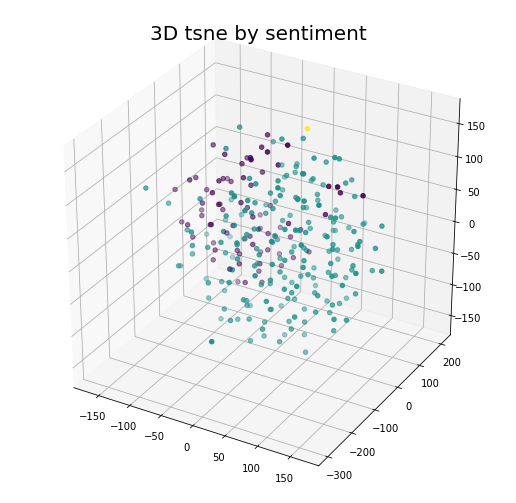

In [190]:
#Visualizing 3D
#scattered one
figure = plt.figure(figsize=(9,9))
axes = figure.add_subplot(111,projection = "3d")
dots = axes.scatter(xs = df_tsne_s.iloc[:,0],ys = df_tsne_s.iloc[:,1],zs = df_tsne_s.iloc[:,2],
                   c = df_tsne_s.sent_num) #cmap = plt.cm.get_cmap("nipy_spectral_r",10))
axes.set_title("3D tsne by sentiment",fontsize=20)
plt.savefig('../tsne_sent.png')